## Coursera - Capstone Project - The Battle of Neighborhoods
## Predicting Residential Units Rental Rates in Riyadh City

### Introduction
The goal of this project is to predict residential units rental rates in Riyadh city for the current year half (first 6 months 2019) to help the target audience of this project to understand the real estate market in the city of Riyadh and study the effect of surrounding venues of each district on the rental rates.

### Data
•	Foursquare.com: Foursqaure API is used here to collect information about the surrounding venues to Riyadh districts such as venue name, venue category, venue coordinates.

•	Address.gov.sa: This API is used in this project to get the location of Riyadh districts and its location boundaries.

•	Aqar.fm: This website has a page that shows residential units rent prices statistics for Riyadh city for each district in a year half time frames.

•	Google MyMaps user map: Included in this project while seaching for Riyadh districts coordinates.

##### Importing very popular and essential libraries in data science projects ( pandas & numpy ).

In [2199]:
import pandas as pd
import numpy as np

### * Google MyMaps *

##### Import libraries required for web scraping.

In [1919]:
#!conda install -c conda-forge folium 
import bs4 as bs
import urllib.request

##### Read web page and parse it using xml parser.

In [2173]:
source = urllib.request.urlopen('https://www.google.com/maps/d/viewer?mid=1CHhkT6F0hT2FlrpE2S_LKDCX5zE&ie=UTF8&hl=ar&t=h&msa=0&ll=24.77489000000001%2C46.72725700000001&spn=0.249379%2C0.326157&z=12&source=embed').read()
soup = bs.BeautifulSoup(source,'lxml')

##### By inspecting the code of the web page we find that the required data ( Districts names & coordinates ) are stored in a java script element.

In [ ]:
print( soup.prettify() )

##### Our data is separated by commas.

In [2175]:
pageData = soup.find('script', attrs={'type':'text/javascript'})

pageDataList = str( pageData ).split( ',')
pageDataList[90]

'[24.793862'

In [2200]:
# Looping through the comma separated list to get neighborhoods names and its coordinates.
Neighborhood = []
Lons = []
Lats = []

for i in range(90,3120,18):
        Lons.append(pageDataList[i])
        Lats.append(pageDataList[i+1])
        Neighborhood.append( pageDataList[i+5] )

Lats[0:5]

['46.638865]\\n',
 '46.652129]\\n',
 '46.66539800000001]\\n',
 '46.689087]\\n',
 '46.669276]\\n']

In [2177]:
# Cleaning the data from extra characters
Neighborhood = [w.replace('[[\\"', '') for w in Neighborhood]
Neighborhood = [w.replace('\\"]\\n]\\n', '') for w in Neighborhood]
Lons = [w.replace('[', '') for w in Lons]
Lats = [w.replace(']\\n', '') for w in Lats]

# Combining the Neighborhood, Lons, Lats lists into one object.
Data_Combined = zip( Neighborhood, Lons, Lats)

# Convert the zip object into pandas DataFrame
df = pd.DataFrame(Data_Combined , columns=['Neighborhood','Lons', 'Lats'])

#converting the latitude & longiude data into floats
df['Lons'] = df['Lons'].astype(float)
df['Lats'] = df['Lats'].astype(float)

# Display the contents of the DataFrame
df.iloc[:10]

,Neighborhood,Lons,Lats
0,الصحافة الجنوبى مربع 1,24.793862,46.638865
1,الربيع الغربى,24.789358,46.652129
2,الربيع الشرقى,24.798075,46.665398
3,الســليــما نــية,24.713343,46.689087
4,ربيع العقارية,24.804860,46.669276
5,تــــالا,24.804502,46.678738
6,الندى الشرقى,24.802631,46.690858
7,الصحافة مربع 2/3/7/8,24.806858,46.639213
8,الصحافة مربع 15/16/23/24,24.814476,46.657007
9,الياسمين 31,24.821072,46.674894


##### Let's display the districts in the Map using folium library.

In [1924]:
import folium
from geopy.geocoders import Nominatim

In [1925]:
# create a folium map for Riyadh city
latitude = df['Lons'][3]
longitude = df['Lats'][3]
map_riyadh_Almosa = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add circle markers to represts Districts in Riyadh city
for i in range(0,len(df)):
    folium.CircleMarker(
        [df.iloc[i]['Lons'], df.iloc[i]['Lats']],
        popup=df.iloc[i]['Neighborhood'],
        radius=5,
        fill = True,
        fill_opacity=0.5
    ).add_to(map_riyadh_Almosa)

# Jupyter notebook didn't render the map with markers.
# map_riyad_Almosa

# Save the result map into drive as a workaround. 
map_riyadh_Almosa.save('c:\\users\\Test\\Map_Riyadh_Almosa.html')

Displaying the map in a markdown cell instead.
<img src='Riyadh_Map_Almosa.jpg'>

##### The coordinates and district can be used, but api.address.gov.sa gives more accurate results.

##### Let's discard this data set for the timebeing and continue collecting other data sets.

## * Aqar *

In [2201]:
# loading Aqar residential units statistics into a soup object.
source = urllib.request.urlopen('https://sa.aqar.fm/%D8%A7%D9%84%D8%A5%D8%AD%D8%B5%D8%A7%D8%A6%D9%8A%D8%A7%D8%AA-%D8%A7%D9%84%D8%B9%D9%82%D8%A7%D8%B1%D9%8A%D8%A9/%D8%A3%D8%B3%D8%B9%D8%A7%D8%B1-%D8%B4%D9%82%D9%82-%D9%84%D9%84%D8%A5%D9%8A%D8%AC%D8%A7%D8%B1').read()
soup = bs.BeautifulSoup(source,'lxml')

 print( soup.prettify() )

##### HTML 'div' elements contains our data set ( neighborhood names and rents rates statistics ) as a collection of HTML tables.
##### Let's scrape the data from the web page, clean it, convert it into pandas dataframe and then display the result.

In [2186]:
# store the HTML 'div' elements contents in soup objects
pageData = soup.find('div', attrs={'class':'statLinksContainer'})
pageNeighborhood = pageData.find_all('span')
pageStats = pageData.find_all('div', attrs={'style':'display:flex;justify-content:flex-end;position:relative;width:100%'})

# Loop thourgh the extracted 'div' elements and extract neighborhood names and rent rates statistics.
listNeighborhood = []
listTables = []
for x in pageStats:
    listNeighborhood.append(x.span.text)
    #listTables.append(x.table)
    table_rows = x.table.find_all('tr')
    iterRows = iter(table_rows)
    next(iterRows)
    for tr in iterRows:
        td = tr.find_all('td')
        row = [tr.text for tr in td]
        row.append(x.span.text)
        listTables.append(row)

# Data preparation and storing it in pandas dataframe
Stats_df = pd.DataFrame(listTables, columns=["priceAverage", "Period", "Neighborhood"] )
Stats_df[['toDrop1','Year_Half', 'Year']] = Stats_df.Period.str.split( expand=True, )
Stats_df[['AveragePrice','toDrop2']] = Stats_df.priceAverage.str.split( expand=True, )
Stats_df.drop(['toDrop1', 'toDrop2', 'priceAverage'], axis=1, inplace=True)

Stats_df['Neighborhood'] = Stats_df['Neighborhood'].str.replace('حي ', '')
Stats_df['AveragePrice'] = Stats_df['AveragePrice'].str.replace(',', '')
Stats_df['Year_Half'] = Stats_df['Year_Half'].str.replace('الأول' , 'First')
Stats_df['Year_Half'] = Stats_df['Year_Half'].str.replace('الثاني' , 'Second')
Stats_df['Year_Half'] = Stats_df['Year_Half'].str.replace('First', '0')
Stats_df['Year_Half'] = Stats_df['Year_Half'].str.replace('Second', '0.5')

Stats_df['AveragePrice'] = Stats_df['AveragePrice'].astype(int)
Stats_df['Year'] = Stats_df['Year'].astype(int)
Stats_df['Year_Half'] = Stats_df['Year_Half'].astype(float)
Stats_df['PeriodVal'] = Stats_df['Year'] + Stats_df['Year_Half']
Stats_df.head(10)

,Period,Neighborhood,Year_Half,Year,AveragePrice,PeriodVal
0,النصف الأول 2015,اشبيلية,0.0,2015,24138,2015.0
1,النصف الثاني 2015,اشبيلية,0.5,2015,24626,2015.5
2,النصف الأول 2016,اشبيلية,0.0,2016,23944,2016.0
3,النصف الثاني 2016,اشبيلية,0.5,2016,22871,2016.5
4,النصف الأول 2017,اشبيلية,0.0,2017,22625,2017.0
5,النصف الثاني 2017,اشبيلية,0.5,2017,20616,2017.5
6,النصف الأول 2018,اشبيلية,0.0,2018,19205,2018.0
7,النصف الثاني 2018,اشبيلية,0.5,2018,18076,2018.5
8,النصف الثاني 2015,الازدهار,0.5,2015,34181,2015.5
9,النصف الأول 2016,الازدهار,0.0,2016,33600,2016.0


##### Data understanding.
##### the Stats_df dataframe has 666 observation and a mean of 23791 of average rent prices of residential units.

In [2187]:
pd.DataFrame(Stats_df['AveragePrice']).describe()

,AveragePrice
count,666.000000
mean,23791.319820
std,6487.063118
min,10666.000000
25%,18025.250000
50%,23590.000000
75%,28795.500000
max,39050.000000


##### Visualize the data as box plot run chart.
##### Average prices started dropping in the second half of 2016.

In [1929]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

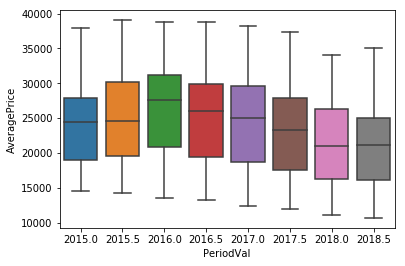

In [2188]:
ax = sns.boxplot(x="PeriodVal", y="AveragePrice", data=Stats_df)

##### Visualize the Means of average prices in a line plot and bar plot.

In [2189]:
Stats_YearHalf_Means = Stats_df.groupby('Period').mean()
Stats_YearHalf_Means.reset_index(inplace=True)
Stats_YearHalf_Means.sort_values(by=['PeriodVal'], inplace=True)

In [2190]:
Stats_YearHalf_Means

,Period,Year_Half,Year,AveragePrice,PeriodVal
0,النصف الأول 2015,0.0,2015.0,24340.628571,2015.0
4,النصف الثاني 2015,0.5,2015.0,25369.472222,2015.5
1,النصف الأول 2016,0.0,2016.0,26537.556962,2016.0
5,النصف الثاني 2016,0.5,2016.0,25044.525773,2016.5
2,النصف الأول 2017,0.0,2017.0,24571.412371,2017.0
6,النصف الثاني 2017,0.5,2017.0,23093.408163,2017.5
3,النصف الأول 2018,0.0,2018.0,21440.770000,2018.0
7,النصف الثاني 2018,0.5,2018.0,21023.306818,2018.5


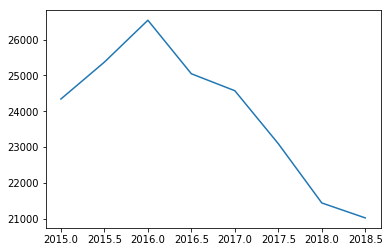

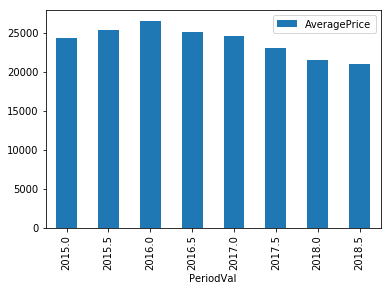

In [2191]:
plt.plot(Stats_YearHalf_Means['PeriodVal'], Stats_YearHalf_Means['AveragePrice'])
ax = Stats_YearHalf_Means.plot.bar(x='PeriodVal', y = 'AveragePrice')

##### Create a pivot dataframe from the Stats_df to get one observation per district/neighborhood.

In [2192]:
Stats_pivot_df = Stats_df.pivot('Neighborhood', 'PeriodVal', 'AveragePrice')
Stats_pivot_df.head(10)

PeriodVal,2015.0,2015.5,2016.0,2016.5,2017.0,2017.5,2018.0,2018.5
Neighborhood,,,,,,,,
أحد,NaN,14700.0,NaN,15000.0,13812.0,14200.0,13833.0,NaN
اشبيلية,24138.0,24626.0,23944.0,22871.0,22625.0,20616.0,19205.0,18076.0
الازدهار,NaN,34181.0,33600.0,30197.0,29635.0,27919.0,26421.0,24209.0
الاندلس,NaN,21800.0,27666.0,26378.0,24754.0,23771.0,21873.0,21250.0
البديعة,NaN,NaN,NaN,NaN,17000.0,15194.0,14608.0,17285.0
التعاون,NaN,39000.0,34882.0,33431.0,31714.0,29450.0,28912.0,28950.0
الجرادية,NaN,NaN,17346.0,17252.0,15554.0,14302.0,13263.0,13584.0
الجزيرة,NaN,NaN,26384.0,27315.0,25032.0,23935.0,22354.0,21850.0
الجنادرية,NaN,18947.0,18437.0,18541.0,17865.0,16936.0,15780.0,14774.0


##### Rename the Neighborhood column to District

In [2193]:
try:
    Stats_pivot_df = pd.DataFrame(Stats_pivot_df.to_records())
except:
    pass

Stats_pivot_df.rename(columns={'Neighborhood':'District'}, inplace=True)
Stats_pivot_df.head()

,District,2015.0,2015.5,2016.0,2016.5,2017.0,2017.5,2018.0,2018.5
0,أحد,NaN,14700.0,NaN,15000.0,13812.0,14200.0,13833.0,NaN
1,اشبيلية,24138.0,24626.0,23944.0,22871.0,22625.0,20616.0,19205.0,18076.0
2,الازدهار,NaN,34181.0,33600.0,30197.0,29635.0,27919.0,26421.0,24209.0
3,الاندلس,NaN,21800.0,27666.0,26378.0,24754.0,23771.0,21873.0,21250.0
4,البديعة,NaN,NaN,NaN,NaN,17000.0,15194.0,14608.0,17285.0


##### The average rent prices are approximately normally distributed.

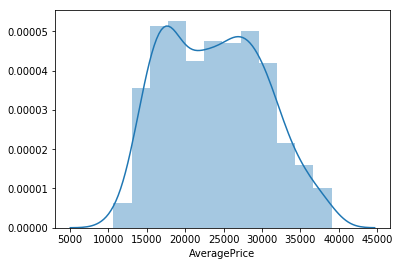

In [2194]:
sns.distplot(Stats_df.AveragePrice)

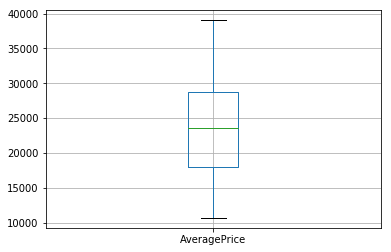

In [2183]:
Stats_df.boxplot(column='AveragePrice')

##### Let's move to another data source which is api.address.gov.sa to get the formal district names with geospatial information.

## * Address API *

### * Districts *

##### The address api requires api_key which is given to the developer after completing registration in the website.
##### The api retrieves data in JSON format.

In [1938]:
import http.client, urllib.request, urllib.parse, urllib.error, base64

In [1940]:
########### Python 3.2 #############


headers = {
    # Request headers
    'api_key': 'YOUR API KEY',
}

params = urllib.parse.urlencode({
    # Request parameters
    'language': 'A',
    'format': 'json',
    'cityid': '3',
})

try:
    conn = http.client.HTTPSConnection('apina.address.gov.sa')
    conn.request("GET", "/NationalAddress/v3.1/lookup/districts?%s" % params, "{body}", headers)
    response = conn.getresponse()
    address_data = response.read()
    #print(address_data)
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))

####################################

##### Storing the JSON response in JSON object and then converting it to a pandas Data Frame.

In [1939]:
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json

In [1941]:
address_data_decode = address_data.decode("windows-1256")

dict_obj = json.loads(address_data_decode)
dict_obj['Districts'][0]['Id']
Districts_df = pd.DataFrame( dict_obj['Districts'])
Districts_df.head(10)

,Id,Name
0,10100003028,المدينة الصناعية الثانية
1,10100003151,جامعة الامام محمد بن سعود الاسلامية
2,10100003166,جامعة الملك سعود
3,10100003059,حي احد
4,10100003137,حي اشبيلية
5,10100003086,حي الازدهار
6,10100003077,حي الاسكان
7,10100003087,حي الاندلس
8,10100003071,حي البديعة
9,10100003094,حي البرية


### * Geo locations *

##### Getting the coordinates of each district using the 'Extents of a Feature' Service in the address API
##### The address api allows one call per 5 seconds for the free account, so we'll use the time library to wait 5 seconds between API calls.

In [1942]:
import time

##### Creating pandas dataframe to hold the location data.

In [1943]:
Geo_df = pd.DataFrame( columns = ['minx', 'miny', 'maxx', 'maxy', 'success', 'result', \
                                  'statusdescription', 'fullexception', 'Id', 'Name'])
Geo_df.astype(str)

,minx,miny,maxx,maxy,success,result,statusdescription,fullexception,Id,Name


##### Loop through the districts dataframe and call the address API to get boundaries of each district

In [ ]:
#Geo_df.drop(Geo_df.index, inplace=True)

for index, row in Districts_df.iterrows():
    params = { "layername": "districts", "featureid": row['Id'], "format": "json"}
    params = urllib.parse.urlencode(params)
    
    try:
        conn = http.client.HTTPSConnection('apina.address.gov.sa')
        conn.request("GET", "/NationalAddress/v3.1/Address/get-feature-extents?%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = response.read()
        print(data)
        conn.close()
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))
        
    address_data_decode = data.decode("windows-1256")
    dict_obj = json.loads(address_data_decode)
    dict_obj.update({'Id':row['Id'], 'Name':row['Name']})
    Geo_df = Geo_df.append(dict_obj , ignore_index=True)
    time.sleep(5)


##### Just to make sure that we don't have any duplicate district Id in the Geo_df data frame.

In [1944]:
#Geo_df.drop(Geo_df.index, inplace=True)
Geo_df = Geo_df.drop_duplicates(subset='Id', keep='first')
Geo_df.head(10)

,minx,miny,maxx,maxy,success,result,statusdescription,fullexception,Id,Name


##### Saving the results into drive to avoid calling the above API calls in case we lost the current session.

In [1329]:
Geo_df.to_csv(r'C:\Users\Test\Downloads\Course\Data Science\Riyadh_Geo.csv')

##### Now we each district name with district Id and location boundaries.

In [1945]:
Geo_df = pd.read_csv(r'C:\Users\Test\Downloads\Course\Data Science\Riyadh_Geo.csv', index_col = 0)
Geo_df.head(10)

C:\Users\Test\Anaconda3\lib\site-packages\IPython\core\displayhook.py:271: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,minx,miny,maxx,maxy,success,result,statusdescription,fullexception,Id,Name
0,46.849667,24.502699,46.946597,24.586056,True,NaN,SUCCESS,NaN,10100003028,المدينة الصناعية الثانية
1,46.687785,24.801407,46.721923,24.830920,True,NaN,SUCCESS,NaN,10100003151,جامعة الامام محمد بن سعود الاسلامية
2,46.602110,24.703914,46.646853,24.744095,True,NaN,SUCCESS,NaN,10100003166,جامعة الملك سعود
3,46.614732,24.472169,46.655266,24.507673,True,NaN,SUCCESS,NaN,10100003059,حي احد
4,46.766300,24.776342,46.818068,24.809261,True,NaN,SUCCESS,NaN,10100003137,حي اشبيلية
5,46.704352,24.768613,46.730595,24.792597,True,NaN,SUCCESS,NaN,10100003086,حي الازدهار
6,46.826500,24.558753,46.869002,24.589107,True,NaN,SUCCESS,NaN,10100003077,حي الاسكان
7,46.774519,24.730206,46.802697,24.756757,True,NaN,SUCCESS,NaN,10100003087,حي الاندلس
8,46.668959,24.605898,46.692829,24.626462,True,NaN,SUCCESS,NaN,10100003071,حي البديعة
9,46.869214,24.498098,47.006928,24.596494,True,NaN,SUCCESS,NaN,10100003094,حي البرية


##### Data preparation for the Geo_df

In [1946]:
Geo_df['minx'] = Geo_df['minx'].astype(float)
Geo_df['miny'] = Geo_df['miny'].astype(float)
Geo_df['maxx'] = Geo_df['maxx'].astype(float)
Geo_df['maxy'] = Geo_df['maxy'].astype(float)
try: 
    Geo_df.drop(['success', 'result', 'statusdescription', 'fullexception'], axis=1, inplace=True) 
except: 
    pass
Geo_df.rename(columns={'Name':'District'}, inplace=True)
Geo_df['District'] = Geo_df['District'].str.replace('حي ', '')
Geo_df.dtypes

minx        float64
miny        float64
maxx        float64
maxy        float64
Id            int64
District     object
dtype: object

In [1947]:
Geo_df.head(10)

,minx,miny,maxx,maxy,Id,District
0,46.849667,24.502699,46.946597,24.586056,10100003028,المدينة الصناعية الثانية
1,46.687785,24.801407,46.721923,24.830920,10100003151,جامعة الامام محمد بن سعود الاسلامية
2,46.602110,24.703914,46.646853,24.744095,10100003166,جامعة الملك سعود
3,46.614732,24.472169,46.655266,24.507673,10100003059,احد
4,46.766300,24.776342,46.818068,24.809261,10100003137,اشبيلية
5,46.704352,24.768613,46.730595,24.792597,10100003086,الازدهار
6,46.826500,24.558753,46.869002,24.589107,10100003077,الاسكان
7,46.774519,24.730206,46.802697,24.756757,10100003087,الاندلس
8,46.668959,24.605898,46.692829,24.626462,10100003071,البديعة
9,46.869214,24.498098,47.006928,24.596494,10100003094,البرية


##### Let's assume that the center of maximum and minimum coordinates represents the district coordinates. 

In [1948]:
Geo_df['longitude'] = ( Geo_df['minx'] + Geo_df['maxx'] ) / 2
Geo_df['latitude'] = ( Geo_df['miny'] + Geo_df['maxy'] ) / 2
Geo_df.rename(columns={'Name':'District'}, inplace=True)
#Geo_df.reset_index(inplace=True)
Geo_df.head(10)

,minx,miny,maxx,maxy,Id,District,longitude,latitude
0,46.849667,24.502699,46.946597,24.586056,10100003028,المدينة الصناعية الثانية,46.898132,24.544378
1,46.687785,24.801407,46.721923,24.830920,10100003151,جامعة الامام محمد بن سعود الاسلامية,46.704854,24.816164
2,46.602110,24.703914,46.646853,24.744095,10100003166,جامعة الملك سعود,46.624481,24.724005
3,46.614732,24.472169,46.655266,24.507673,10100003059,احد,46.634999,24.489921
4,46.766300,24.776342,46.818068,24.809261,10100003137,اشبيلية,46.792184,24.792802
5,46.704352,24.768613,46.730595,24.792597,10100003086,الازدهار,46.717473,24.780605
6,46.826500,24.558753,46.869002,24.589107,10100003077,الاسكان,46.847751,24.573930
7,46.774519,24.730206,46.802697,24.756757,10100003087,الاندلس,46.788608,24.743482
8,46.668959,24.605898,46.692829,24.626462,10100003071,البديعة,46.680894,24.616180
9,46.869214,24.498098,47.006928,24.596494,10100003094,البرية,46.938071,24.547296


##### Displaying the districts list retrieved from address api in a folium map.

In [1949]:
latitude = Geo_df['latitude'][15]
longitude = Geo_df['longitude'][15]
map_riyadh_districts = folium.Map(location=[latitude, longitude], zoom_start=10)

for i in range(0,len(df)):
    folium.CircleMarker(
        [Geo_df.iloc[i]['latitude'], Geo_df.iloc[i]['longitude']],
        popup=Geo_df.iloc[i]['District'],
        radius=5,
        fill = True,
        fill_opacity=0.5
    ).add_to(map_riyadh_districts)

map_riyadh_districts.save('c:\\users\\Test\\Riyadh_Map_Districts.html')

<img src='Riyadh_Map_Districts_01.jpg'>
<img src='Riyadh_Map_Districts_02.jpg'>

##### To make a choropleth map we need to create GeoJson file since it is not publicly available.
##### We will assume that all districts in Riyadh city have rectangular shape.
##### Depending on the minimum and maximum points we can create a geopandas polygon object using shapely points.

In [1950]:
from shapely.geometry import Polygon
import geopandas as gpd

In [1951]:
GeoList = []
for i in range(0, len(Geo_df)):
    x1 = Geo_df.iloc[i]['minx']
    y1 = Geo_df.iloc[i]['miny']
    x2 = Geo_df.iloc[i]['maxx']
    y2 = Geo_df.iloc[i]['maxy']
    GeoList.append(Polygon( [(x1,y1), (x2,y1), (x2, y2), (x1, y2), (x1, y1)] ) )

GeoList[:3]

##### Creating the GeoJson file using geopandas library.

In [1952]:
Geo_Json = gpd.GeoSeries(GeoList).to_json()
with open(r"C:\Users\Test\Downloads\Course\Data Science\Riyadh_01.GeoJson", "w") as text_file:
    text_file.write(Geo_Json)

##### The GeoList can be plotted so that we have an idea how it will be displayed on the map.

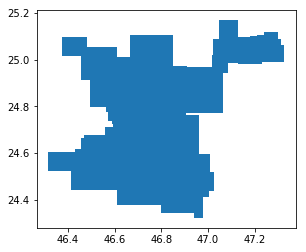

In [1953]:
gpd.GeoSeries(GeoList).plot()

##### Display the GeoJson data in the map using folium choropleth method.

In [1954]:
latitude = Geo_df['latitude'][15]
longitude = Geo_df['longitude'][15]
map_riyadh_choropleth_01 = folium.Map(location=[latitude, longitude], zoom_start=10)

In [1955]:
map_geo = r"C:\Users\Test\Downloads\Course\Data Science\Riyadh_01.GeoJson"
map_riyadh_choropleth_01.choropleth(
 geo_data=map_geo,
 name='choropleth',
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.5,
 line_opacity=0.2,
)
folium.LayerControl().add_to(map_riyadh_choropleth_01)

map_riyadh_choropleth_01.save('c:\\users\\Test\\Riyadh_map_choropleth_01.html')

<img src='Riyadh_Map_Choropleth_01.jpg'>

##### The shape have many overlapped rectangles.
##### Let's try enhance the shape by decreasing the rectangles sizes by 15%.

In [1956]:
Geo_df.head()

,minx,miny,maxx,maxy,Id,District,longitude,latitude
0,46.849667,24.502699,46.946597,24.586056,10100003028,المدينة الصناعية الثانية,46.898132,24.544378
1,46.687785,24.801407,46.721923,24.830920,10100003151,جامعة الامام محمد بن سعود الاسلامية,46.704854,24.816164
2,46.602110,24.703914,46.646853,24.744095,10100003166,جامعة الملك سعود,46.624481,24.724005
3,46.614732,24.472169,46.655266,24.507673,10100003059,احد,46.634999,24.489921
4,46.766300,24.776342,46.818068,24.809261,10100003137,اشبيلية,46.792184,24.792802


In [1957]:
scale_ratio = 0.15

Geo_df['minx'] = Geo_df['minx'] + (Geo_df['maxx']-Geo_df['minx']) * scale_ratio
Geo_df['miny'] = Geo_df['miny'] + (Geo_df['maxy']-Geo_df['miny']) * scale_ratio
Geo_df['maxx'] = Geo_df['maxx'] - (Geo_df['maxx']-Geo_df['minx']) * scale_ratio
Geo_df['maxy'] = Geo_df['maxy'] - (Geo_df['maxy']-Geo_df['miny']) * scale_ratio

Geo_df.head()

,minx,miny,maxx,maxy,Id,District,longitude,latitude
0,46.864206,24.515202,46.934238,24.575428,10100003028,المدينة الصناعية الثانية,46.898132,24.544378
1,46.692906,24.805834,46.717570,24.827157,10100003151,جامعة الامام محمد بن سعود الاسلامية,46.704854,24.816164
2,46.608821,24.709941,46.641148,24.738972,10100003166,جامعة الملك سعود,46.624481,24.724005
3,46.620812,24.477494,46.650098,24.503146,10100003059,احد,46.634999,24.489921
4,46.774065,24.781280,46.811468,24.805064,10100003137,اشبيلية,46.792184,24.792802


##### And we will rotate the rectangles by -25 degrees around the rectangles centroids.
##### but first we need to create a new polygon shape for each rectangle and store them in a list ( GeoList ).

In [1958]:
GeoList = []
for i in range(0, len(Geo_df)):
    x1 = Geo_df.iloc[i]['minx']
    y1 = Geo_df.iloc[i]['miny']
    x2 = Geo_df.iloc[i]['maxx']
    y2 = Geo_df.iloc[i]['maxy']
    GeoList.append(Polygon( [(x1,y1), (x2,y1), (x2, y2), (x1, y2), (x1, y1)] ) )

In [1959]:
len(GeoList)

187

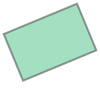

In [2205]:
GeoList[0]

In [1961]:
print(GeoList[0])

POLYGON ((46.86420629300218 24.51520233729032, 46.93423827110918 24.51520233729032, 46.93423827110918 24.57542830583388, 46.86420629300218 24.57542830583388, 46.86420629300218 24.51520233729032))


##### To rorate the rectangles we can use affinity in the shapely library to do that.

In [1962]:
from shapely import affinity

In [1963]:
for i in range(0, len(GeoList)):
    GeoList[i] = affinity.rotate(GeoList[i], 25, origin='centroid') 

In [1964]:
len(GeoList)

187

##### The shape are now rotates by -25 degrees around it's centroids.

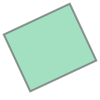

In [1965]:
GeoList[0]

In [1966]:
print(GeoList[0])

POLYGON ((46.88021331557446 24.50322529299875, 46.94368384267442 24.5328220858526, 46.91823124853689 24.58740535012545, 46.85476072143693 24.5578085572716, 46.88021331557446 24.50322529299875))


##### Converting the GeoList back into a GeoJson file.

In [1967]:
Geo_Json_22 = gpd.GeoSeries(GeoList).to_json()
with open(r"C:\Users\Test\Downloads\Course\Data Science\Riyadh_22.GeoJson", "w") as text_file:
    text_file.write(Geo_Json_22)

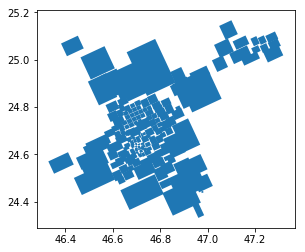

In [1968]:
gpd.GeoSeries(GeoList).plot()

##### Let's find out how it will look like in a folium map.

In [1969]:
latitude = Geo_df['latitude'][15]
longitude = Geo_df['longitude'][15]
map_riyadh_choropleth_22 = folium.Map(location=[latitude, longitude], zoom_start=10)

In [1970]:
map_riyadh_choropleth_22

In [1971]:
map_geo_22 = r"C:\Users\Test\Downloads\Course\Data Science\Riyadh_22.GeoJson"
map_riyadh_choropleth_22.choropleth(
 geo_data=map_geo_22,
 name='choropleth',
 fill_color='YlGn',
 fill_opacity=0.5,
 line_opacity=0.2,
)
folium.LayerControl().add_to(map_riyadh_choropleth_22)

map_riyadh_choropleth_22.save('c:\\users\\Test\\map_riyadh_choropleth_22.html')

<img src='Riyadh_Map_Choropleth_22.jpg'>

### * Riyadh Choropleth map *

##### First table is Stats_pivot_df. It contains one observation for each district \
##### with average rent prices of residential units over year halfs time frames as attributes

In [1972]:
Stats_pivot_df.head()

,District,2015.0,2015.5,2016.0,2016.5,2017.0,2017.5,2018.0,2018.5
0,أحد,NaN,14700.0,NaN,15000.0,13812.0,14200.0,13833.0,NaN
1,اشبيلية,24138.0,24626.0,23944.0,22871.0,22625.0,20616.0,19205.0,18076.0
2,الازدهار,NaN,34181.0,33600.0,30197.0,29635.0,27919.0,26421.0,24209.0
3,الاندلس,NaN,21800.0,27666.0,26378.0,24754.0,23771.0,21873.0,21250.0
4,البديعة,NaN,NaN,NaN,NaN,17000.0,15194.0,14608.0,17285.0


In [1973]:
try:
    Stats_pivot_df.reset_index(inplace=True)
except:
    pass
#Stats_pivot_df.drop(columns='PeriodVal',axis=1)
Stats_pivot_df.head()

,index,District,2015.0,2015.5,2016.0,2016.5,2017.0,2017.5,2018.0,2018.5
0,0,أحد,NaN,14700.0,NaN,15000.0,13812.0,14200.0,13833.0,NaN
1,1,اشبيلية,24138.0,24626.0,23944.0,22871.0,22625.0,20616.0,19205.0,18076.0
2,2,الازدهار,NaN,34181.0,33600.0,30197.0,29635.0,27919.0,26421.0,24209.0
3,3,الاندلس,NaN,21800.0,27666.0,26378.0,24754.0,23771.0,21873.0,21250.0
4,4,البديعة,NaN,NaN,NaN,NaN,17000.0,15194.0,14608.0,17285.0


##### Second table is Geo_df. and it contains District name along with their coordinates.

In [1974]:
Geo_df.head()

,minx,miny,maxx,maxy,Id,District,longitude,latitude
0,46.864206,24.515202,46.934238,24.575428,10100003028,المدينة الصناعية الثانية,46.898132,24.544378
1,46.692906,24.805834,46.717570,24.827157,10100003151,جامعة الامام محمد بن سعود الاسلامية,46.704854,24.816164
2,46.608821,24.709941,46.641148,24.738972,10100003166,جامعة الملك سعود,46.624481,24.724005
3,46.620812,24.477494,46.650098,24.503146,10100003059,احد,46.634999,24.489921
4,46.774065,24.781280,46.811468,24.805064,10100003137,اشبيلية,46.792184,24.792802


##### By joining the two table together we get 97 districts matched by name.

In [1975]:
Geo_Stats_df = pd.merge(Stats_pivot_df, Geo_df, how='inner', on = 'District')
print( Geo_Stats_df.shape)
Geo_Stats_df.head()

(97, 17)


,index,District,2015.0,2015.5,2016.0,2016.5,2017.0,2017.5,2018.0,2018.5,minx,miny,maxx,maxy,Id,longitude,latitude
0,1,اشبيلية,24138.0,24626.0,23944.0,22871.0,22625.0,20616.0,19205.0,18076.0,46.774065,24.781280,46.811468,24.805064,10100003137,46.792184,24.792802
1,2,الازدهار,NaN,34181.0,33600.0,30197.0,29635.0,27919.0,26421.0,24209.0,46.708288,24.772211,46.727249,24.789539,10100003086,46.717473,24.780605
2,3,الاندلس,NaN,21800.0,27666.0,26378.0,24754.0,23771.0,21873.0,21250.0,46.778746,24.734189,46.799104,24.753372,10100003087,46.788608,24.743482
3,4,البديعة,NaN,NaN,NaN,NaN,17000.0,15194.0,14608.0,17285.0,46.672539,24.608983,46.689786,24.623840,10100003071,46.680894,24.616180
4,5,التعاون,NaN,39000.0,34882.0,33431.0,31714.0,29450.0,28912.0,28950.0,46.690325,24.764640,46.709307,24.781982,10100003085,46.699520,24.773041


##### The average prices in 2018 H2 will be input data to the choropleth map. Let's make drop any observation with missing data in this Half.

In [1976]:
Geo_Stats_df.dropna(subset=['2018.5'], inplace=True)
Geo_Stats_df.shape

(86, 17)

##### 11 observations dropped due to inavailability of average prices.

#### rotating the rectangles by -22.5 degrees was better than -25 degrees.

In [ ]:
GeoList = []
for i in range(0, len(Geo_Stats_df)):
    x1 = Geo_Stats_df.iloc[i]['minx']
    y1 = Geo_Stats_df.iloc[i]['miny']
    x2 = Geo_Stats_df.iloc[i]['maxx']
    y2 = Geo_Stats_df.iloc[i]['maxy']
    GeoList.append(Polygon( [(x1,y1), (x2,y1), (x2, y2), (x1, y2), (x1, y1)] ) )

for i in range(0, len(GeoList)):
    GeoList[i] = affinity.rotate(GeoList[i], 22.5, origin='centroid') 

GeoSer = gpd.GeoSeries(GeoList)
GeoDF = gpd.GeoDataFrame(GeoSer)
GeoDF = GeoDF.rename(columns={0:'geometry'})
GeoDF.set_geometry('geometry')
GeoDF['id']=Geo_Stats_df['Id'].values
    
Geo_Json_03 = GeoDF.to_json()
with open(r"C:\Users\Test\Downloads\Course\Data Science\Riyadh_03.GeoJson", "w") as text_file:
    text_file.write(Geo_Json_03)

##### Let's display the results in a folium choropleth map.

In [1977]:
latitude = Geo_Stats_df['latitude'][15]
longitude = Geo_Stats_df['longitude'][15]
map_riyadh_choropleth_03 = folium.Map(location=[latitude, longitude], zoom_start=10)

map_geo_03 = r"C:\Users\Test\Downloads\Course\Data Science\Riyadh_03.GeoJson"
map_riyadh_choropleth_03.choropleth(
 geo_data=map_geo_03,
 name='choropleth',
 data=Geo_Stats_df,
 columns=['Id', '2018.5'],
 key_on='properties.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 #legend_name='Unemployment Rate (%)'
)
folium.LayerControl().add_to(map_riyadh_choropleth_03)

map_riyadh_choropleth_03.save('c:\\users\\Test\\map_riyadh_choropleth_03.html')

<img src='Riyadh_Map_Choropleth_03.jpg'>

##### The map shows that districts in the center and north west of Riyadh city have higher rent prices than the other locations in the city.

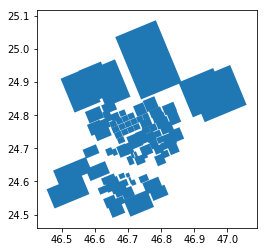

In [1979]:
GeoSer = gpd.GeoSeries(GeoList)
GeoSer.plot()

### * FourSquare API  *

##### Now we will get the near by venues for riyadh districts using FourSquare API.

In [2207]:
CLIENT_ID = 'FourSqare ID' # your Foursquare ID
CLIENT_SECRET = 'FourSquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FourSqare ID
CLIENT_SECRET:FourSquare Secret


In [1537]:
Geo_Stats_df.loc[19, 'District']

'الروضة'

In [1538]:
i = 19
district_latitude = Geo_Stats_df.loc[i, 'latitude']
district_longitude = Geo_Stats_df.loc[i, 'longitude'] 

#neighborhood_latitude = 24.7136
#neighborhood_longitude = 46.6753

district_name = Geo_Stats_df.loc[i, 'District'] #

print('Latitude and longitude values of {} are {}, {}.'.format(district_name, 
                                                               district_latitude, 
                                                               district_longitude))

Latitude and longitude values of الروضة are 24.733827669289504, 46.767914404087406.


In [1539]:
latitude = district_latitude
longitude = district_longitude
radius = 2000
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=5JE0E3FOXGVACK0SU13CMEUDDVCGMXAESVUKYVD0LPFIJDNV&client_secret=SAAYJPKHY0KJYENTC1VPL4OTOZVKTG2MMCG0GBEEWIDCUA5R&ll=24.733827669289504,46.767914404087406&v=20180605&radius=2000&limit=100'

In [ ]:
results = requests.get(url).json()
results

In [1541]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

##### 'Al Rawda' district in Riyadh city has these nearby venues in addition to venue categories.

In [1544]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Al Hatab Bakery (أفران الحطب),Bakery,24.732104,46.765266
1,Juice Time,Juice Bar,24.732160,46.765153
2,بوفية فهد كبدة غنم وحاشي,Breakfast Spot,24.731759,46.765830
3,ركن قراميشو,Candy Store,24.734315,46.763464
4,Broast Line (بروست لاين),Fried Chicken Joint,24.732988,46.764510
5,Shawarama Majed (شاورما ماجد),Fast Food Restaurant,24.732121,46.764773
6,ورق عنب,Food Service,24.732731,46.764614
7,Combo Nation (كومبو نيشن),Burger Joint,24.729524,46.767030
8,Tawa (تاوة),Dessert Shop,24.731817,46.765382
9,Dunkin' Donuts (دانكن دونتس),Donut Shop,24.731092,46.771104


##### Defining a fuction to get the nearby venues for each district in Riyadh city with radius of 2000 Meters.

In [1545]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [1555]:
venues = getNearbyVenues(names=Geo_Stats_df['District'],
                                   latitudes=Geo_Stats_df['latitude'],
                                   longitudes=Geo_Stats_df['longitude']
                                  )

اشبيلية
الازدهار
الاندلس
البديعة
التعاون
الجرادية
الجزيرة
الجنادرية
الحزم
الحمراء
الخليج
الدار البيضاء
الربوة
الربيع
الرمال
الروابي
الروضة
الريان
الزهرة
السعادة
السلام
السليمانية
السويدي
السويدي الغربي
الشفا
الشهداء
الصحافة
الضباط
العارض
العريجاء الوسطى
العزيزية
العقيق
العليا
الغدير
الفلاح
الفيحاء
القادسية
القدس
القيروان
المربع
المرسلات
المروة
المروج
المصيف
المعيزلة
المغرزات
الملز
الملقا
الملك عبدالعزيز
الملك عبدالله
الملك فهد
الملك فيصل
المنار
المنصورة
المونسية
النخيل
الندى
النرجس
النزهة
النسيم الشرقي
النسيم الغربي
النظيم
النفل
النهضة
الوادي
الورود
الوزارات
الياسمين
اليرموك
اليمامة
ام الحمام الشرقي
ام الحمام الغربي
بدر
جرير
حطين
شبرا
طويق
ظهرة البديعة
ظهرة لبن
عتيقة
عرقة
عكاظ
غرناطة
قرطبة
لبن
نمار


##### Saving the venues Data Frame to Drive to avoid calling the api again in case we lost the session.

In [1556]:
venues.to_csv(r'C:\Users\Test\Downloads\Course\Data Science\venues.csv')

In [1980]:
venues = pd.read_csv(r'C:\Users\Test\Downloads\Course\Data Science\venues.csv')

##### Great. The API retrieved 6710 records.

In [1981]:
print(venues.shape)
venues_grouped = venues.groupby('Neighborhood').count()

(6710, 8)


In [1982]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 278 uniques categories.


In [1983]:
print('There are {} uniques districts.'.format(len(venues['Neighborhood'].unique())))

There are 85 uniques districts.


##### Converting the records into features using one hot encoding.

In [1984]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.columns.values

array(['Neighborhood', 'ATM', 'Accessories Store', 'Afghan Restaurant',
       'Airport', 'American Restaurant', 'Amphitheater', 'Antique Shop',
       'Aquarium', 'Arcade', 'Arepa Restaurant', 'Art Gallery',
       'Arts & Crafts Store', 'Asian Restaurant', 'Assisted Living',
       'Athletics & Sports', 'Auto Garage', 'Auto Workshop',
       'Automotive Shop', 'BBQ Joint', 'Bagel Shop', 'Bakery', 'Bank',
       'Bar', 'Baseball Field', 'Basketball Court', 'Bathing Area',
       'Beach', 'Bed & Breakfast', 'Beer Garden', 'Belgian Restaurant',
       'Big Box Store', 'Bistro', 'Boarding House', 'Bookstore',
       'Botanical Garden', 'Boutique', 'Bowling Alley', 'Boxing Gym',
       'Breakfast Spot', 'Bridal Shop', 'Bubble Tea Shop', 'Buffet',
       'Building', 'Burger Joint', 'Bus Station', 'Business Service',
       'Butcher', 'Café', 'Cajun / Creole Restaurant', 'Camera Store',
       'Campground', 'Candy Store', 'Cantonese Restaurant',
       'Chinese Restaurant', 'Chocolate Shop'

##### Let's get how frequent venue categories for each district in Riyadh.

In [1985]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped.head(10)

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,...,Vacation Rental,Video Game Store,Video Store,Watch Shop,Water Park,Waterfall,Wings Joint,Women's Store,Yoga Studio,Zoo
0,اشبيلية,0.020000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0
1,الازدهار,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
2,الاندلس,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
3,البديعة,0.022727,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
4,التعاون,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0
5,الجرادية,0.000000,0.0,0.012821,0.0,0.000000,0.0,0.012821,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
6,الجزيرة,0.000000,0.0,0.000000,0.0,0.013889,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
7,الجنادرية,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
8,الحزم,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
9,الحمراء,0.000000,0.0,0.000000,0.0,0.040000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0


In [1986]:
grouped.shape

(85, 279)

##### Sorting venue categories by most common categories for the districts.

In [ ]:
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [1988]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [1989]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,اشبيلية,Donut Shop,Dessert Shop,Fast Food Restaurant,Coffee Shop,Middle Eastern Restaurant,Gym / Fitness Center,Supermarket,Sandwich Place,Ice Cream Shop,Pizza Place
1,الازدهار,Coffee Shop,Cosmetics Shop,Juice Bar,Pharmacy,Breakfast Spot,Dessert Shop,Restaurant,Burger Joint,Health Food Store,Ice Cream Shop
2,الاندلس,Coffee Shop,Ice Cream Shop,Middle Eastern Restaurant,Donut Shop,Fast Food Restaurant,Pharmacy,Breakfast Spot,Pizza Place,Bakery,Café
3,البديعة,Coffee Shop,Fast Food Restaurant,Park,Grocery Store,Café,Donut Shop,Pizza Place,Farm,Ice Cream Shop,Convenience Store
4,التعاون,Coffee Shop,Ice Cream Shop,Pharmacy,Fast Food Restaurant,Burger Joint,Restaurant,Donut Shop,Gift Shop,Dessert Shop,Café


##### Clustering Riyadh districts based on frequency of venue categories.

In [1990]:
from sklearn.cluster import KMeans

##### Selecting the number of clusters to 10 after some trials.

In [1991]:
# set number of clusters
kclusters = 10

grouped_clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:85]

array([1, 0, 1, 0, 0, 1, 1, 2, 1, 4, 1, 1, 4, 0, 3, 4, 4, 4, 4, 1, 1, 4,
       1, 4, 1, 0, 1, 0, 9, 1, 1, 4, 0, 4, 0, 1, 6, 4, 7, 0, 0, 1, 0, 0,
       1, 0, 1, 4, 4, 4, 0, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 4, 1, 0, 0, 0,
       4, 1, 1, 0, 1, 6, 1, 4, 1, 1, 4, 4, 1, 1, 8, 4, 0, 1, 1])

In [1992]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [1993]:
neighborhoods_venues_sorted.rename(columns={'Neighborhood':'District'}, inplace=True)

In [1994]:
merged = Geo_Stats_df

# merge grouped with data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

merged.dropna(subset=['Cluster Labels'], inplace=True)
merged['Cluster Labels'] = merged['Cluster Labels'].astype(int)

merged.columns.values

array(['index', 'District', '2015.0', '2015.5', '2016.0', '2016.5',
       '2017.0', '2017.5', '2018.0', '2018.5', 'minx', 'miny', 'maxx',
       'maxy', 'Id', 'longitude', 'latitude', 'Cluster Labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'], dtype=object)

##### Let's add the clusters to the previous choropleth map using color coded circle markers.

In [1997]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [1998]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [2168]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['latitude'], merged['longitude'], merged['District'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_riyadh_choropleth_03)
       
map_riyadh_choropleth_03.save('c:\\users\\Test\\riyadh_map_clusters.html')

<img src="riyadh_map_clusters.jpg">

##### From the map we can see that districts in cluster 0 ( Blue circle marker ) have High average rent prices.
##### And districts in cluster 1 ( Purple circle markers ) have low average rent prices.
##### And districts in cluster 4 ( red circle marker ) have medium to high average rent prices.
##### Other clusters can be discarded.

In [2000]:
merged['Cluster Labels'].value_counts()

1    33
0    23
4    21
6     2
9     1
8     1
7     1
5     1
3     1
2     1
Name: Cluster Labels, dtype: int64

##### Cluster 0 have Coffe Shops and Hotel usually as most common venue categories.

In [2197]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[1] + list(range(5, merged.shape[1]))]].head(10)

,District,2016.5,2017.0,2017.5,2018.0,2018.5,minx,miny,maxx,maxy,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,الازدهار,30197.0,29635.0,27919.0,26421.0,24209.0,46.708288,24.772211,46.727249,24.789539,...,Coffee Shop,Cosmetics Shop,Juice Bar,Pharmacy,Breakfast Spot,Dessert Shop,Restaurant,Burger Joint,Health Food Store,Ice Cream Shop
3,البديعة,NaN,17000.0,15194.0,14608.0,17285.0,46.672539,24.608983,46.689786,24.623840,...,Coffee Shop,Fast Food Restaurant,Park,Grocery Store,Café,Donut Shop,Pizza Place,Farm,Ice Cream Shop,Convenience Store
4,التعاون,33431.0,31714.0,29450.0,28912.0,28950.0,46.690325,24.764640,46.709307,24.781982,...,Coffee Shop,Ice Cream Shop,Pharmacy,Fast Food Restaurant,Burger Joint,Restaurant,Donut Shop,Gift Shop,Dessert Shop,Café
15,الربيع,35353.0,34382.0,31777.0,31346.0,29333.0,46.648465,24.783816,46.673669,24.806298,...,Coffee Shop,Café,Dessert Shop,Bakery,Pizza Place,Gym / Fitness Center,Restaurant,Donut Shop,Fast Food Restaurant,Supermarket
29,الشهداء,29407.0,28375.0,28980.0,25563.0,20000.0,46.726246,24.779767,46.745205,24.797111,...,Coffee Shop,Cosmetics Shop,Donut Shop,Hotel,Café,Clothing Store,Pharmacy,Frozen Yogurt Shop,Burger Joint,Middle Eastern Restaurant
31,الضباط,30351.0,32829.0,29889.0,27135.0,28811.0,46.719696,24.670504,46.727659,24.690109,...,Coffee Shop,Donut Shop,Sandwich Place,Hotel,Middle Eastern Restaurant,Indian Restaurant,Fast Food Restaurant,Café,Bakery,Breakfast Spot
36,العليا,36509.0,34482.0,34630.0,33658.0,30978.0,46.669545,24.675447,46.698337,24.710313,...,Coffee Shop,Jewelry Store,Café,Hotel,Boutique,Spa,Men's Store,Dessert Shop,French Restaurant,Flower Shop
38,الفلاح,32064.0,30297.0,31228.0,28081.0,27631.0,46.700040,24.788643,46.718969,24.805981,...,Coffee Shop,Donut Shop,Falafel Restaurant,Hotel,Breakfast Spot,Burger Joint,Café,Gift Shop,Dessert Shop,Pharmacy
44,المربع,27483.0,35528.0,26062.0,25544.0,23571.0,46.699178,24.649940,46.715356,24.676661,...,Coffee Shop,Hotel,Pizza Place,Breakfast Spot,Indian Restaurant,Café,Sandwich Place,Asian Restaurant,Middle Eastern Restaurant,Donut Shop
45,المرسلات,30571.0,30800.0,29660.0,27729.0,26100.0,46.680656,24.740342,46.699738,24.757935,...,Coffee Shop,Café,Donut Shop,Jewelry Store,Cosmetics Shop,Middle Eastern Restaurant,Ice Cream Shop,Juice Bar,Breakfast Spot,Furniture / Home Store


##### Cluster 1 usually have Fast Food Restaurant and Middle Eastern Restaurant as most common venue categories.

In [2198]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[1] + list(range(5, merged.shape[1]))]].head(20)

,District,2016.5,2017.0,2017.5,2018.0,2018.5,minx,miny,maxx,maxy,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,اشبيلية,22871.0,22625.0,20616.0,19205.0,18076.0,46.774065,24.781280,46.811468,24.805064,...,Donut Shop,Dessert Shop,Fast Food Restaurant,Coffee Shop,Middle Eastern Restaurant,Gym / Fitness Center,Supermarket,Sandwich Place,Ice Cream Shop,Pizza Place
2,الاندلس,26378.0,24754.0,23771.0,21873.0,21250.0,46.778746,24.734189,46.799104,24.753372,...,Coffee Shop,Ice Cream Shop,Middle Eastern Restaurant,Donut Shop,Fast Food Restaurant,Pharmacy,Breakfast Spot,Pizza Place,Bakery,Café
5,الجرادية,17252.0,15554.0,14302.0,13263.0,13584.0,46.693682,24.612688,46.704836,24.625119,...,Shopping Mall,Pizza Place,Fast Food Restaurant,Coffee Shop,Ice Cream Shop,Sandwich Place,Diner,Donut Shop,Breakfast Spot,Market
6,الجزيرة,27315.0,25032.0,23935.0,22354.0,21850.0,46.783227,24.649687,46.810470,24.680621,...,Furniture / Home Store,Coffee Shop,Fast Food Restaurant,Electronics Store,Breakfast Spot,Café,Auto Workshop,Shopping Mall,Clothing Store,Department Store
8,الحزم,17175.0,16105.0,15952.0,14891.0,14994.0,46.629196,24.523448,46.664404,24.554336,...,Burger Joint,Hookah Bar,Fast Food Restaurant,Café,Coffee Shop,Shawarma Place,Supermarket,Ice Cream Shop,Pizza Place,Breakfast Spot
11,الخليج,22318.0,22105.0,19519.0,18154.0,17922.0,46.784442,24.762757,46.822717,24.791657,...,Bakery,Middle Eastern Restaurant,Burger Joint,Pizza Place,Sandwich Place,Coffee Shop,Donut Shop,Restaurant,Gym / Fitness Center,Fast Food Restaurant
12,الدار البيضاء,17378.0,16764.0,15578.0,14332.0,13744.0,46.768328,24.549262,46.817775,24.581684,...,Grocery Store,Gym,Donut Shop,Cupcake Shop,Boxing Gym,Fried Chicken Joint,Sporting Goods Shop,Middle Eastern Restaurant,Seafood Restaurant,Market
22,السعادة,22095.0,21080.0,19847.0,18352.0,17366.0,46.822711,24.683597,46.851440,24.712485,...,Fast Food Restaurant,Middle Eastern Restaurant,Pizza Place,Hookah Bar,Soccer Field,Resort,Rest Area,Gym / Fitness Center,Food Truck,Café
23,السلام,25587.0,25903.0,22801.0,22738.0,21340.0,46.799676,24.697302,46.823465,24.718909,...,Pizza Place,Breakfast Spot,Donut Shop,Falafel Restaurant,Burger Joint,Gym / Fitness Center,Middle Eastern Restaurant,Fast Food Restaurant,Market,Fried Chicken Joint
25,السويدي,18366.0,18630.0,17896.0,16720.0,15380.0,46.660854,24.581052,46.699737,24.601127,...,Burger Joint,Coffee Shop,Fast Food Restaurant,Middle Eastern Restaurant,Ice Cream Shop,Fried Chicken Joint,Food Truck,Pet Store,Breakfast Spot,Shawarma Place


##### Cluster 4 usually have Coffee Shops and Dessert Shops as most common venue categories.

In [2003]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[1] + list(range(5, merged.shape[1]))]].head(10)

,District,2016.5,2017.0,2017.5,2018.0,2018.5,minx,miny,maxx,maxy,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,الحمراء,28555.0,27309.0,24911.0,23219.0,22959.0,46.737480,24.764528,46.770644,24.787202,...,Coffee Shop,Dessert Shop,Pizza Place,Donut Shop,Middle Eastern Restaurant,American Restaurant,Café,Ice Cream Shop,Food Truck,Furniture / Home Store
14,الربوة,28750.0,28818.0,26083.0,24718.0,25925.0,46.738410,24.679252,46.771697,24.709211,...,Coffee Shop,Bakery,Pizza Place,Fast Food Restaurant,Donut Shop,Dessert Shop,Gym / Fitness Center,Café,Grocery Store,Juice Bar
18,الروابي,27656.0,24884.0,24224.0,21064.0,22395.0,46.778890,24.684532,46.804954,24.708377,...,Dessert Shop,Middle Eastern Restaurant,Ice Cream Shop,Donut Shop,Bakery,Coffee Shop,Café,Burger Joint,Gym / Fitness Center,Breakfast Spot
19,الروضة,26791.0,26318.0,24177.0,23579.0,24264.0,46.754547,24.720297,46.782142,24.748228,...,Dessert Shop,Coffee Shop,Donut Shop,Fast Food Restaurant,Burger Joint,Café,Juice Bar,Gift Shop,Pharmacy,Middle Eastern Restaurant
20,الريان,31086.0,29200.0,30270.0,24276.0,22571.0,46.766698,24.699679,46.790531,24.723691,...,Coffee Shop,Dessert Shop,Ice Cream Shop,Donut Shop,Sandwich Place,Burger Joint,Pharmacy,Gym / Fitness Center,Fast Food Restaurant,Pizza Place
21,الزهرة,20650.0,NaN,18160.0,17869.0,17687.0,46.634917,24.569052,46.657284,24.588870,...,Coffee Shop,Dessert Shop,Bakery,Juice Bar,Falafel Restaurant,Pizza Place,Café,Donut Shop,Ice Cream Shop,Middle Eastern Restaurant
24,السليمانية,35453.0,34023.0,33283.0,31836.0,30100.0,46.687362,24.682351,46.713441,24.715474,...,Coffee Shop,Café,Burger Joint,Dessert Shop,Steakhouse,Middle Eastern Restaurant,Ice Cream Shop,Men's Store,Cupcake Shop,Gym / Fitness Center
26,السويدي الغربي,18811.0,19402.0,17317.0,17477.0,17650.0,46.610952,24.564496,46.639416,24.584989,...,Dessert Shop,Café,Coffee Shop,Burger Joint,Pizza Place,Fast Food Restaurant,Gym / Fitness Center,Bakery,Falafel Restaurant,Ice Cream Shop
35,العقيق,29718.0,29337.0,26721.0,25906.0,24454.0,46.617895,24.759488,46.642847,24.788639,...,Coffee Shop,Café,Ice Cream Shop,Gym / Fitness Center,Pharmacy,Bakery,Dessert Shop,Middle Eastern Restaurant,Food Truck,Burger Joint
37,الغدير,34000.0,33333.0,32602.0,30627.0,31166.0,46.644936,24.764793,46.664860,24.783059,...,Dessert Shop,Burger Joint,Hotel,Gym / Fitness Center,Ice Cream Shop,Breakfast Spot,Donut Shop,Middle Eastern Restaurant,Coffee Shop,Pharmacy


##### Let's merged the three clusters in one data frame.

In [2004]:
clustered_df = merged[(merged['Cluster Labels'] == 0) | (merged['Cluster Labels'] == 1) | (merged['Cluster Labels'] == 4)]
clustered_df.head()

,index,District,2015.0,2015.5,2016.0,2016.5,2017.0,2017.5,2018.0,2018.5,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,اشبيلية,24138.0,24626.0,23944.0,22871.0,22625.0,20616.0,19205.0,18076.0,...,Donut Shop,Dessert Shop,Fast Food Restaurant,Coffee Shop,Middle Eastern Restaurant,Gym / Fitness Center,Supermarket,Sandwich Place,Ice Cream Shop,Pizza Place
1,2,الازدهار,NaN,34181.0,33600.0,30197.0,29635.0,27919.0,26421.0,24209.0,...,Coffee Shop,Cosmetics Shop,Juice Bar,Pharmacy,Breakfast Spot,Dessert Shop,Restaurant,Burger Joint,Health Food Store,Ice Cream Shop
2,3,الاندلس,NaN,21800.0,27666.0,26378.0,24754.0,23771.0,21873.0,21250.0,...,Coffee Shop,Ice Cream Shop,Middle Eastern Restaurant,Donut Shop,Fast Food Restaurant,Pharmacy,Breakfast Spot,Pizza Place,Bakery,Café
3,4,البديعة,NaN,NaN,NaN,NaN,17000.0,15194.0,14608.0,17285.0,...,Coffee Shop,Fast Food Restaurant,Park,Grocery Store,Café,Donut Shop,Pizza Place,Farm,Ice Cream Shop,Convenience Store
4,5,التعاون,NaN,39000.0,34882.0,33431.0,31714.0,29450.0,28912.0,28950.0,...,Coffee Shop,Ice Cream Shop,Pharmacy,Fast Food Restaurant,Burger Joint,Restaurant,Donut Shop,Gift Shop,Dessert Shop,Café


##### Box plots will help us in knowing that there is a correlation between the three clusters and its average residential units rent prices.

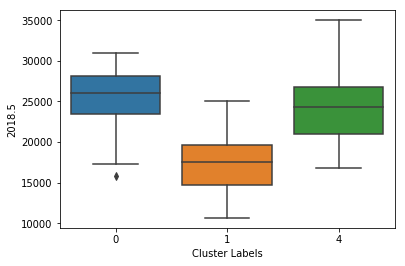

In [2005]:
ax = sns.boxplot(x="Cluster Labels", y="2018.5", data=clustered_df)

##### Seaborn displot will help in knowing if we have a normally distributed data.

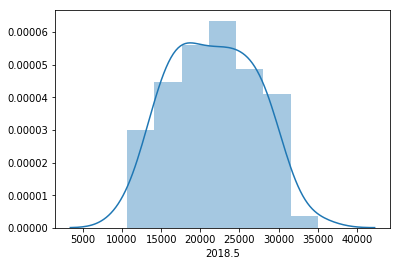

In [2006]:
sns.distplot(clustered_df['2018.5'])

In [2007]:
clustered_df.columns.values

array(['index', 'District', '2015.0', '2015.5', '2016.0', '2016.5',
       '2017.0', '2017.5', '2018.0', '2018.5', 'minx', 'miny', 'maxx',
       'maxy', 'Id', 'longitude', 'latitude', 'Cluster Labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'], dtype=object)

##### Filtering only required columns after clustering Riyadh districts.

In [2008]:
clustered_df = clustered_df[['District', '2015.0', '2015.5', '2016.0', '2016.5',
       '2017.0', '2017.5', '2018.0', '2018.5', 'Id', 'Cluster Labels']]
clustered_df.head()

,District,2015.0,2015.5,2016.0,2016.5,2017.0,2017.5,2018.0,2018.5,Id,Cluster Labels
0,اشبيلية,24138.0,24626.0,23944.0,22871.0,22625.0,20616.0,19205.0,18076.0,10100003137,1
1,الازدهار,NaN,34181.0,33600.0,30197.0,29635.0,27919.0,26421.0,24209.0,10100003086,0
2,الاندلس,NaN,21800.0,27666.0,26378.0,24754.0,23771.0,21873.0,21250.0,10100003087,1
3,البديعة,NaN,NaN,NaN,NaN,17000.0,15194.0,14608.0,17285.0,10100003071,0
4,التعاون,NaN,39000.0,34882.0,33431.0,31714.0,29450.0,28912.0,28950.0,10100003085,0


In [2120]:
clustered_df_c0 = clustered_df[clustered_df['Cluster Labels'] == 0]
clustered_df_c1 = clustered_df[clustered_df['Cluster Labels'] == 1]
clustered_df_c4 = clustered_df[clustered_df['Cluster Labels'] == 4]
clustered_df_c0 = clustered_df_c0[['2015.0', '2015.5', '2016.0', '2016.5', '2017.0', '2017.5', '2018.0', '2018.5']]
clustered_df_c1 = clustered_df_c1[['2015.0', '2015.5', '2016.0', '2016.5', '2017.0', '2017.5', '2018.0', '2018.5']]
clustered_df_c4 = clustered_df_c4[['2015.0', '2015.5', '2016.0', '2016.5', '2017.0', '2017.5', '2018.0', '2018.5']]

##### Let's compare the average residential unit prices for each cluster in a line plot.

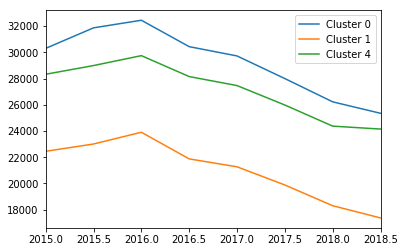

In [2121]:
fig, ax = plt.subplots()
clustered_df_c0.mean().plot(kind='line', ax=ax)
clustered_df_c1.mean().plot(kind='line', ax=ax)
clustered_df_c4.mean().plot(kind='line', ax=ax)
ax.legend(['Cluster 0', 'Cluster 1', 'Cluster 4'])

##### To simplify the problem before applying regression models, we will take Means of average prices for each cluster and store in a dataframe.
##### The dataframes are transposed to be ready as an input to regression algorithms.

In [2122]:
clustered_df_c0_T = pd.DataFrame( clustered_df_c0.mean().T )
clustered_df_c0_T.reset_index(inplace=True)
clustered_df_c0_T.rename(columns={'index':'YearHalf', 0:'AveragePrice'}, inplace=True)

clustered_df_c1_T = pd.DataFrame( clustered_df_c1.mean().T )
clustered_df_c1_T.reset_index(inplace=True)
clustered_df_c1_T.rename(columns={'index':'YearHalf', 0:'AveragePrice'}, inplace=True)

clustered_df_c4_T = pd.DataFrame( clustered_df_c4.mean().T )
clustered_df_c4_T.reset_index(inplace=True)
clustered_df_c4_T.rename(columns={'index':'YearHalf', 0:'AveragePrice'}, inplace=True)

##### The YearHalf Attribute is of type 'object', Let's convert it to float to input it to regression algorithms.

In [2124]:
print( clustered_df_c0_T.dtypes )
clustered_df_c0_T

YearHalf         object
AveragePrice    float64
dtype: object


,YearHalf,AveragePrice
0,2015.0,30300.000000
1,2015.5,31864.642857
2,2016.0,32444.526316
3,2016.5,30429.863636
4,2017.0,29721.956522
5,2017.5,27995.826087
6,2018.0,26220.695652
7,2018.5,25347.173913


In [2125]:
# Converting the YearHalf to float data types.
clustered_df_c0_T['YearHalf'] = clustered_df_c0_T['YearHalf'].astype(float)
clustered_df_c1_T['YearHalf'] = clustered_df_c1_T['YearHalf'].astype(float)
clustered_df_c4_T['YearHalf'] = clustered_df_c4_T['YearHalf'].astype(float)

##### Splitting the data into training and test data.
##### 2018 H2 is selected as test data.

In [2142]:
#x_train = clustered_df_c0_train_T[['YearHalf']]
#y_train = clustered_df_c0_train_T[['AveragePrice']]
x_c0_train = pd.DataFrame( clustered_df_c0_T.iloc[0:7, 0])
y_c0_train = pd.DataFrame( clustered_df_c0_T.iloc[0:7, 1])
x_c0_test = pd.DataFrame( clustered_df_c0_T.iloc[7:8, 0])
y_c0_test = pd.DataFrame( clustered_df_c0_T.iloc[7:8, 1])

x_c1_train = pd.DataFrame( clustered_df_c1_T.iloc[0:7, 0])
y_c1_train = pd.DataFrame( clustered_df_c1_T.iloc[0:7, 1])
x_c1_test = pd.DataFrame( clustered_df_c1_T.iloc[7:8, 0])
y_c1_test = pd.DataFrame( clustered_df_c1_T.iloc[7:8, 1])

x_c4_train = pd.DataFrame( clustered_df_c4_T.iloc[0:7, 0])
y_c4_train = pd.DataFrame( clustered_df_c4_T.iloc[0:7, 1])
x_c4_test = pd.DataFrame( clustered_df_c4_T.iloc[7:8, 0])
y_c4_test = pd.DataFrame( clustered_df_c4_T.iloc[7:8, 1])

print( x_c0_train, '\n',  y_c0_train, '\n', x_c0_test, '\n', y_c0_test)

   YearHalf
0    2015.0
1    2015.5
2    2016.0
3    2016.5
4    2017.0
5    2017.5
6    2018.0 
    AveragePrice
0  30300.000000
1  31864.642857
2  32444.526316
3  30429.863636
4  29721.956522
5  27995.826087
6  26220.695652 
    YearHalf
7    2018.5 
    AveragePrice
7  25347.173913


In [2143]:
print( x_c0_train.dtypes , '\n', y_c0_train.dtypes )

YearHalf    float64
dtype: object 
 AveragePrice    float64
dtype: object


##### Building our regression model.
##### Trying Linear Regression as first step.

In [2040]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2144]:
model = LinearRegression()
model.fit(x_c0_train, y_c0_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [2145]:
print( "R-squared: ",  model.score(x_c0_train,y_c0_train) )
print( "Coeffiecient: " , model.coef_)
print ('Intercept: ',model.intercept_)

R-squared:  0.6582018812031676
Coeffiecient:  [[-1621.29402699]]
Intercept:  [3299193.33558416]


In [2146]:
yhat = model.predict(x_c0_test)
print( 'pridected average price (Cluster 0, 2018.5): ', yhat )
print( 'Actual average price: (Cluster 0, 2018.5)', y_test.values )

pridected average price (Cluster 0, 2018.5):  [[26611.34209889]]
Actual average price: (Cluster 0, 2018.5) [[25347.17391304]]


##### Comparing Linear Regression model equation with Actual average prices.

Text(0, 0.5, 'Average Price')

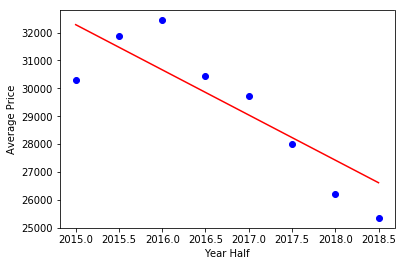

In [2147]:
plt.scatter(clustered_df_c0_T[['YearHalf']], clustered_df_c0_T[['AveragePrice']],  color='blue')
plt.plot(clustered_df_c0_T[['YearHalf']], model.coef_[0][0]*clustered_df_c0_T[['YearHalf']] + model.intercept_[0], '-r')
plt.xlabel("Year Half")
plt.ylabel("Average Price")

##### Model evaluation results.

In [2091]:
from sklearn.metrics import r2_score

In [2148]:
test_x = np.asanyarray(x_c0_test)
test_y = np.asanyarray(y_c0_test)
test_y_hat = model.predict(test_x)

print(test_x)
print(test_y)
print(test_y_hat)
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
#print("R2-score: %.2f" % r2_score(test_y_hat , test_y))

[[2018.5]]
[[25347.17391304]]
[[26611.34209889]]
Mean absolute error: 1264.17
Residual sum of squares (MSE): 1598121.20


##### Let's try building other model types. ( Polynomial Regression ).

In [2102]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

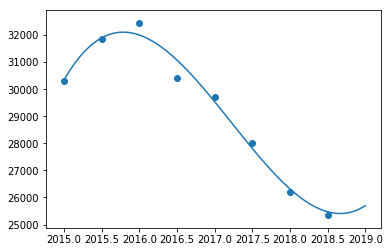

In [2162]:
model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

x = np.asanyarray(x_c0_train)
y = np.asanyarray(y_c0_train)

model.fit(x, y);

# Plotting
xAll = np.asanyarray(clustered_df_c0_T[['YearHalf']])
yAll = np.asanyarray(clustered_df_c0_T[['AveragePrice']])
xSpace = np.linspace(min(xAll), max(xAll)+0.5, 100)
plt.plot(xSpace, model.predict(xSpace))
plt.scatter(xAll, yAll)


##### Polynomial Regression have good evaluation results when compared to linear regression.

In [2150]:
test_x = np.asanyarray(x_c0_test)
test_y = np.asanyarray(y_c0_test)
test_y_hat = model.predict(test_x)

print(test_x)
print(test_y)
print(test_y_hat)
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
#print("R2-score: %.2f" % r2_score(test_y_hat , test_y))

[[2018.5]]
[[25347.17391304]]
[[25471.77148438]]
Mean absolute error: 124.60
Residual sum of squares (MSE): 15524.55


##### Applying polynomial regression to cluster 1

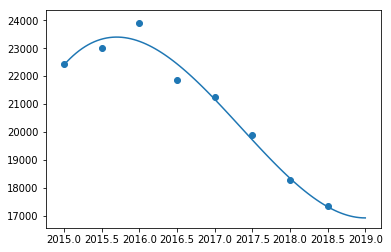

In [2163]:
model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

x = np.asanyarray(x_c1_train)
y = np.asanyarray(y_c1_train)

model.fit(x, y);

# Plotting
xAll = np.asanyarray(clustered_df_c1_T[['YearHalf']])
yAll = np.asanyarray(clustered_df_c1_T[['AveragePrice']])
xSpace = np.linspace(min(xAll), max(xAll)+0.5, 100)
plt.plot(xSpace, model.predict(xSpace))
plt.scatter(xAll, yAll)

##### Cluster 1 Model Evaluation

In [2153]:
test_x = np.asanyarray(x_c1_test)
test_y = np.asanyarray(y_c1_test)
test_y_hat = model.predict(test_x)

print(test_x)
print(test_y)
print(test_y_hat)
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))

[[2018.5]]
[[17366.60606061]]
[[17329.88818359]]
Mean absolute error: 36.72
Residual sum of squares (MSE): 1348.20


##### Creating a model for cluster 4 using polynomial regression

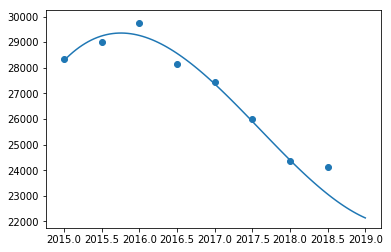

In [2209]:
model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

x = np.asanyarray(x_c4_train)
y = np.asanyarray(y_c4_train)

model.fit(x, y);

# Plotting
xAll = np.asanyarray(clustered_df_c4_T[['YearHalf']])
yAll = np.asanyarray(clustered_df_c4_T[['AveragePrice']])
xSpace = np.linspace(min(xAll), max(xAll)+0.5, 100)
plt.plot(xSpace, model.predict(xSpace))
plt.scatter(xAll, yAll)

##### Model Evaluation

In [2159]:
test_x = np.asanyarray(x_c4_test)
test_y = np.asanyarray(y_c4_test)
test_y_hat = model.predict(test_x)

print(test_x)
print(test_y)
print(test_y_hat)
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))

[[2018.5]]
[[24143.28571429]]
[[23064.66967773]]
Mean absolute error: 1078.62
Residual sum of squares (MSE): 1163412.55


##### Results from building polynomial regression models:
##### Average rent prices for cluster 0 will increaese slightly during 2019 H1
##### Average rent prices for cluster 1 will keep dropping during 2019 H1
##### AVerage rent prices for cluster 4 will keep dropping during 2019 H1

##### Further discussion and conclusion can be found in the this project report in the same GitHub repository of this project.

##### Thanks for reviewing this project.
Alaa Jaradat